# This notebook containts analysis for ASO 50m snow depths

In [1]:
import pandas as pd
import numpy as np

from skimage import io
from datetime import timedelta
from datetime import datetime
from scipy.stats import pearsonr
from subprocess import run
import imageio # for gifs
import glob
import os

# Imports for plotting
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.ticker import NullFormatter 
from matplotlib.ticker import MultipleLocator, FormatStrFormatter 
from matplotlib.dates import MonthLocator
import matplotlib.patheffects as PathEffects

from mpl_toolkits.axes_grid1 import make_axes_locatable

### set up paths

In [2]:
# mask and DEM
mask_50m_path = '/home/meganmason/Documents/projects/thesis/data/processing_lidar/depths_50m/tuolx_hetchy_mask_50m.asc'
dem_50m_path = '/home/meganmason/Documents/projects/thesis/data/processing_lidar/depths_50m/tuolx_dem_50m.asc'

# ASO snow depth surfaces
depth_50m_path = '/home/meganmason/Documents/projects/thesis/data/processing_lidar/depths_50m/ASO_50m_depth_surfaces/asc/*.asc'
depth_50m_years = list(range(2013,2018))

### extract flight dates from filenames

In [3]:
flist = glob.glob(depth_50m_path)
print('Number of files as input:', len(flist))

flight_dates = []

for f in sorted(flist):
    dt_str = f.split("/")[-1] #splits on '/' and saves the last one
    dt_str = "".join([c for c in dt_str if c.isnumeric()]) #grabs numeric values for date info
    flight_dates.append(dt_str) #append to flight_date list

# flight_dates # flight dates as strings

flight_dates_dt = [datetime.strptime(flight_date, '%Y%m%d') for flight_date in flight_dates]
# print(flight_dates_dt[1] - flight_dates_dt[0])
# print(type(flight_dates_dt))    

Number of files as input: 47


### show mask, dem, and example lidar

mask shape: (1339, 1374) 
dem shape: (1339, 1374) 
example lidar shape: (1339, 1374)

mask type: <class 'numpy.ndarray'> 
dem type: <class 'numpy.ndarray'> 
example lidar type: <class 'numpy.ndarray'>


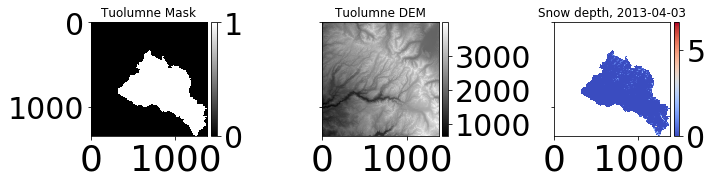

In [61]:
mask_50m = np.loadtxt(mask_50m_path, skiprows=6)
dem_50m = np.loadtxt(dem_50m_path, skiprows=6)
ex_depth = np.loadtxt(flist[0], skiprows=6)

print('mask shape:', mask_50m.shape, 
      '\ndem shape:', dem_50m.shape, 
      '\nexample lidar shape:', ex_depth.shape)

print('\nmask type:', type(mask_50m), 
      '\ndem type:', type(dem_50m), 
      '\nexample lidar type:', type(ex_depth))


f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(10,6))
#mask
im1 = ax1.imshow(mask_50m, cmap='gray')
ax1.set_title('Tuolumne Mask')
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im1, cax=cax)
#dem
im2 = ax2.imshow(dem_50m, cmap='gray')
ax2.set_title('Tuolumne DEM')
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im2, cax=cax)
#snow depth, 1 of 48
ex_depth_aux = ex_depth
ex_depth_aux[ex_depth_aux <= -0.001] = np.nan
im3 = ax3.imshow(ex_depth_aux, cmap='coolwarm') #PLOT WHERE VALUES ARE > ZERO  ????
ax3.set_title('Snow depth, {}'.format(flight_dates_dt[0].date())) 
divider = make_axes_locatable(ax3)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im3, cax=cax)

plt.tight_layout()

In [5]:
flight_period = {}
for year in range(2013,2018):

    flight_period[year] = [flight_dates_dt[i_date+1] - flight_dates_dt[i_date] 
                           for i_date in range(len(flight_dates_dt)-1) 
                           if (year == flight_dates_dt[i_date+1].year) & (year == flight_dates_dt[i_date].year)]
    
    print('frequencies for {}: {} - {} days'.format(year, min(flight_period[year]).days, max(flight_period[year]).days))

frequencies for 2013: 4 - 26 days
frequencies for 2014: 4 - 15 days
frequencies for 2015: 4 - 27 days
frequencies for 2016: 5 - 18 days
frequencies for 2017: 8 - 35 days


### Tuolumne Basin Mean Snow Depth 

In [58]:
# ~~ Function 1, mean snow depth
def mean_snow_depth(depth_array, convert_factor = 1e-3, mask_array = None, mask_value = None):
    '''
    Gets mean snow depth for ASO snow depth surfaces
        args:
            depth_array: numpy array from asc files
            dx: cellsize [m] in x direction
            dy: cellsize [m] in y direction
            convert_factor: (optional, default is 0.001 from mm to m)
            mask_array: (Optional) mask of the area for SWE calculation
                       If no mask is provided will calculate for entire array
            mask_value: (Optional) value of the mask to calculate over
                       Default value will be any positive integer
           Note: swe_array and mask_array should cover the same extent 
                 and have the same dx,dy
       return:
           mean_depth: mean depth [m] over the area in mask
                       or the full area in the array if no mask is provided
    '''
    
    if mask_array is None:
        mean_depth = np.nanmean(depth_array[(depth_array > 0)])
        sca = depth_array[(depth_array > 0)].size / mask_array[mask_array == mask_value].size
        
    else:
        mean_depth = np.nanmean(depth_array[[(mask_array == mask_value) & (depth_array > 0)]])
        sca = depth_array[[(mask_array == mask_value) & (depth_array > 0)]].size / mask_array[mask_array == mask_value].size
        
    return mean_depth, sca

In [59]:
# call Function 1
mean_depths = []
sca = []

for f in sorted(flist):
    depth_array = np.loadtxt(f, skiprows=6) #load asc files
    mean_d, sca_ = mean_snow_depth(depth_array, mask_array=mask_50m, mask_value=np.max(mask_50m)) #call mean_snow_depth function
    mean_depths.append(mean_d)
    sca.append(sca_)

# mean_depths #returns list of mean snow depths

mean_depth_df = pd.DataFrame(data = mean_depths, index = flight_dates_dt, columns = ['mean_snow_depth'])
sca_df = pd.DataFrame(data = sca, index = flight_dates_dt, columns = ['sca'])
mean_depth_df #returns dataframe of mean snow depths
sca_df

/home/meganmason/Documents/projects/thesis/analysis/virtual_envs/data_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home/meganmason/Documents/projects/thesis/analysis/virtual_envs/data_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


,sca
2013-04-03,0.849147
2013-04-29,0.744057
2013-05-03,0.694359
2013-05-25,0.474969
2013-06-01,0.403301
2013-06-08,0.326324
2014-03-23,0.834711
2014-04-07,0.888735
2014-04-13,0.825119
2014-04-20,0.778334


In [8]:
# ~~ Function 2, peak mean snow depth per year
def get_peak(datetime_list, series_list, years):
    '''
    Calculates yearly peak SWE
    input:
        datetime_list: list containing the datetime stamps for the time series
        series_list: list with the time series of SWE values
        years: list with years to analyze
    return:
        peak_df: yearly peak value dataframe with datetime_peak as index and peak value in column
    '''
    
    
    df_series = pd.DataFrame(data = series_list, index = datetime_list, columns = ['series'])
    
    for year in years:
        df_year = df_series.truncate(before = str(year) + '-01', after = str(year) + '-12')
        if year == years[0]:
            peak_df = pd.DataFrame(data = [df_year.max(axis = 0).values[0]], index = [df_year.idxmax(axis = 0).values[0]], columns = ['peak mean depth'])
        else:
            peak_df.loc[df_year.idxmax(axis = 0).values[0]] = df_year.max(axis = 0).values[0]
    
    return peak_df

In [9]:
# call Function 2
peak_mean_depth_df = get_peak(flight_dates_dt, mean_depths, depth_50m_years)
peak_mean_depth_df # returns dataframe of peak mean snow depths, 1 per year

,peak mean depth
2013-04-03,0.856148
2014-04-07,0.819292
2015-02-18,0.413889
2016-03-26,1.650550
2017-03-03,3.220474


[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4. ]


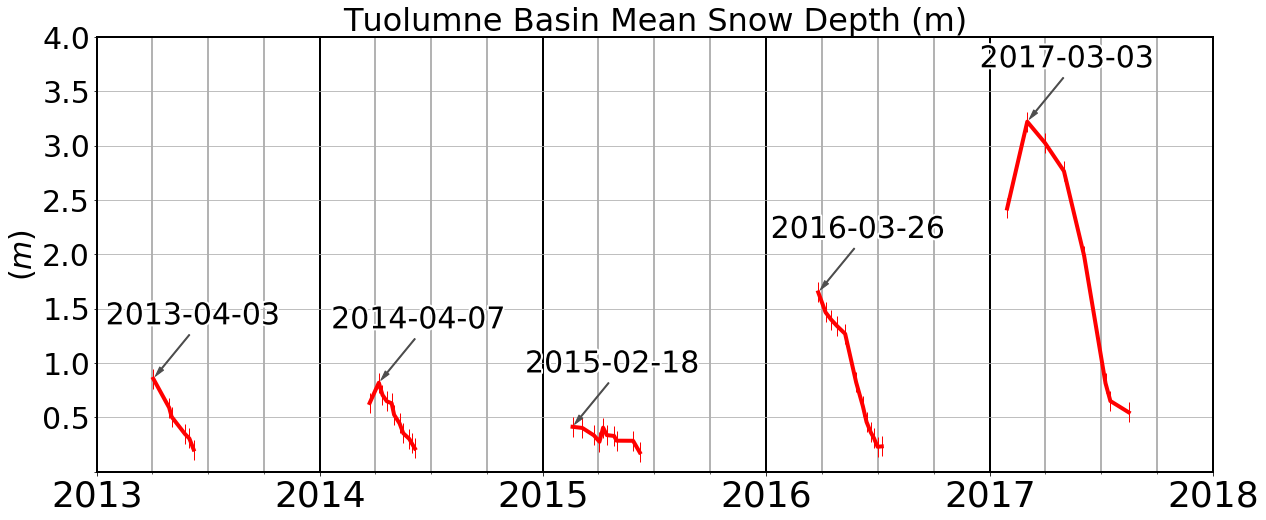

In [48]:
#use:
# mean_depth_df (func 1)
# peak_mean_depth_df (func 2)

minorLocator = MultipleLocator(365/2)
fs_titles = 32
fs_labels = 26
fs_axes = 26
fs_text = 26
fs_legend = 26

plt.figure(figsize=(20,8))
ax = plt.subplot(1, 1, 1)

i_plot = 0
for year in depth_50m_years: #(list(range(2013,2018)))
    depth_year = mean_depth_df.truncate(before = str(year) + '-01', after = str(year) + '-12')
    h_plot = plt.plot_date(depth_year.index, depth_year.values, fmt='x', tz=None, xdate=True, ydate=False)
    
    plt.setp(h_plot, marker='|', markersize=20, color='r', linestyle = '-', linewidth = '4')
    
    h_text_date = plt.annotate(str(peak_mean_depth_df.index[i_plot])[:10], xy=(peak_mean_depth_df.index[i_plot], peak_mean_depth_df.iloc[i_plot]), 
                               xytext=(peak_mean_depth_df.index[i_plot]+pd.Timedelta('65 days'), peak_mean_depth_df.iloc[i_plot] + 0.5),
                arrowprops=dict(shrink=0.05, width=1, headlength = 10, headwidth = 5, edgecolor= (0.3, 0.3, 0.3), facecolor= (0.3, 0.3, 0.3)),
                fontsize = fs_text+4, horizontalalignment='center')
    
    h_text_date.set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])
    
#     h_text_date.set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])

    i_plot += 1

plt.title('Tuolumne Basin Mean Snow Depth (m)', fontsize = fs_titles)
plt.ylabel('$(m)$',fontsize = fs_labels + 4)
plt.axes().xaxis.set_minor_locator(MonthLocator(bymonth = [4, 7, 10]))
plt.rc('xtick', labelsize = fs_axes+10)    # fontsize of the tick labels
plt.rc('ytick', labelsize = fs_axes+4)    # fontsize of the tick labels
plt.ylim([0, 4])
plt.grid(True)
plt.grid(axis='both', color=(0.7, 0.7, 0.7), which='minor', linestyle='-', linewidth=2)
plt.grid(axis='x', color='k', which='major', linestyle='-', linewidth=2)
plt.xlim([pd.to_datetime('2013-01-01'), pd.to_datetime('2018-01-01')])

y_ticks = np.array(list(range(0, 45, 5)))/10
print(y_ticks)
y_ticklabels = [str(y_tick) for y_tick in y_ticks]
y_ticklabels[0] = ''
plt.yticks(y_ticks, y_ticklabels)

ax.spines['top'].set_linewidth(2.0)
ax.spines['bottom'].set_linewidth(2.0)
ax.spines['left'].set_linewidth(2.0)
ax.spines['right'].set_linewidth(2.0)
    
    

In [33]:
print(peak_mean_depth_df)
print('s',str(peak_mean_depth_df.index[0])[:10])
print('x',peak_mean_depth_df.index[0])
print('y',peak_mean_depth_df.iloc[0,0])

            peak mean depth
2013-04-03         0.856148
2014-04-07         0.819292
2015-02-18         0.413889
2016-03-26         1.650550
2017-03-03         3.220474
s 2013-04-03
x 2013-04-03 00:00:00
y 0.8561479769179567
